# atomman demonstration

This Notebook provides a demonstration of many of the features of atomman as we go through the process of constructing a periodic array of dislocations atomic configuration.


Before using, you will need:

- atomman installed for Python (from conda-forge or pip)
- A LAMMPS executable
- The MPI command for running LAMMPS in parallel (optional)


In [1]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman.unitconvert as uc
import atomman.lammps as lmp
import atomman as am

## Specify LAMMPS and MPI commands

- lammps_command is the LAMMPS executable you want to use
- mpi_command is the MPI executable and options you want to use with LAMMPS. Setting as None will run LAMMPS serially.

In [2]:
lammps_command = 'lmp_mpi'

#mpi_command = None # Serial run
mpi_command = 'C:/Program Files/MPICH2/bin/mpiexec -localonly 6'

## Load LAMMPS potential from database

In [3]:
db = am.library.Database(load='lammps_potentials', verbose=True)

Loaded 276 local LAMMPS potentials
Loaded 276 remote LAMMPS potentials
 - 0 new


In [4]:
db.lammps_potentials_df

,id,key,potid,potkey,units,atom_style,allsymbols,pair_style,status,symbols,elements,masses,charges
0,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,062d2ba7-3903-40ae-a772-daa471d107c6,1985--Foiles-S-M--Ni-Cu,301f04ce-9082-4542-8590-489300cd19e8,metal,atomic,False,eam,active,"[Cu, Ni]","[Cu, Ni]","[63.55, 58.71]","[0.0, 0.0]"
1,1985--Stillinger-F-H--Si--LAMMPS--ipr1,d085648c-b3ef-4be8-824b-7093fd22770a,1985--Stillinger-F-H-Weber-T-A--Si,edc31ad6-2b9a-455c-9b5f-e888a672ecbd,metal,atomic,False,sw,active,[Si],[Si],[28.085],[0.0]
2,1986--Foiles-S-M--Ag--LAMMPS--ipr1,76a265fc-45ff-49d7-8c64-2044f12402f2,1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag,672d54f8-9f48-4200-af56-8a7378ebbc4a,metal,atomic,False,eam,active,[Ag],[Ag],[107.87],[0.0]
3,1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1,c5afa7e8-6b3b-49cd-ad1c-ae3e4329363a,1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag-Au-Cu-...,7a1302de-59cf-4efb-900e-cad845b68ee5,metal,atomic,False,eam,active,"[Ag, Au, Cu, Ni, Pd, Pt]","[Ag, Au, Cu, Ni, Pd, Pt]","[107.87, 196.97, 63.55, 58.71, 106.4, 195.09]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,1986--Foiles-S-M--Au--LAMMPS--ipr1,c588810a-b96d-4871-bfe2-cff8a5a7c709,1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Au,ffb66faa-319d-4556-8363-dad3959cd553,metal,atomic,False,eam,active,[Au],[Au],[196.97],[0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2019--Duan-X--Ta-He--LAMMPS--ipr1,d6608123-3432-453e-ab94-b55822e7df12,2019--Duan-X-Xie-F-Guo-X-et-al--Ta-He,278faa04-d121-4744-875d-e085f0b0e5da,metal,atomic,True,hybrid,active,"[Ta, He]","[Ta, He]","[180.94788, 4.002602]","[0.0, 0.0]"
272,2019--Mendelev-M-I--Cu-Zr--LAMMPS--ipr1,73d03486-1b34-4a24-b1d2-4da253abdda0,2019--Mendelev-M-I--Cu-Zr,2e5ed18c-5fb4-46e4-ae7a-5f50d9429d95,metal,atomic,False,eam/fs,active,"[Cu, Zr]","[Cu, Zr]","[63.546, 91.224]","[0.0, 0.0]"
273,2019--Mendelev-M-I--Fe-Ni-Cr--LAMMPS--ipr1,43aa1b40-dce4-48cf-8e4f-fb0e079180b6,2019--Mendelev-M-I--Fe-Ni-Cr,6c5d342a-7e25-467f-a234-d937301f6bc4,metal,atomic,False,eam/fs,active,"[Fe, Ni, Cr]","[Fe, Ni, Cr]","[55.845, 58.6934, 51.9961]","[0.0, 0.0, 0.0]"
274,2020--Byggmastar-J--Fe--LAMMPS--ipr1,a1d123a0-eba2-4271-962c-720d9d564a9b,2020--Byggmastar-J-Granberg-F--Fe,114b0f72-8f6d-4ac1-82fb-ac15fd6b7bde,metal,atomic,False,tersoff/zbl,active,[Fe],[Fe],[55.845],[0.0]


Parse for potentials with Ag

In [5]:
def hassymbol(series, symbol):
    return symbol in series.symbols

pot_ids = db.lammps_potentials_df[db.lammps_potentials_df.apply(hassymbol, args=['Ag'], axis=1)].id.tolist()

for i, pot_id in enumerate(pot_ids):
    print(i, pot_id)

0 1986--Foiles-S-M--Ag--LAMMPS--ipr1
1 1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1
2 1987--Ackland-G-J--Ag--LAMMPS--ipr1
3 1987--Ackland-G-J--Ag--LAMMPS--ipr2
4 1989--Adams-J-B--Ag--LAMMPS--ipr1
5 1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1
6 2004--Zhou-X-W--Ag--LAMMPS--ipr2
7 2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2
8 2006--Williams-P-L--Ag--LAMMPS--ipr1
9 2006--Williams-P-L--Cu-Ag--LAMMPS--ipr1
10 2009--Wu-H-H--Cu-Ag--LAMMPS--ipr1
11 2013--Gao-H--AgTaO3--LAMMPS--ipr2
12 2013--Hale-L-M--Pd-Ag-H-Hybrid--LAMMPS--ipr1
13 2013--Hale-L-M--Pd-Ag-H-Morse--LAMMPS--ipr1
14 2018--Pan-Z--Ag-Ni--LAMMPS--ipr1


Select a potential and check LAMMPS input commands. Note: get_files=True will copy/download parameter files to the working directory.

In [6]:
potential = am.load_lammps_potential(id=pot_ids[3], get_files=True, database=db)
print(potential)
print(potential.pair_info('Ag'))

1987--Ackland-G-J--Ag--LAMMPS--ipr2
mass 1 107.8682

pair_style eam/fs
pair_coeff * * 1987--Ackland-G-J--Ag--LAMMPS--ipr2\Ag_v2.eam.fs Ag



## Load crystal

This searches the 25,000+ unique relaxed crystals in the database, allowing users to find potential-specific equilibrium parameters.

In [7]:
ucell = am.load('crystal', potential=potential,
                symbols='Ag',
                #family='A1--Cu--fcc',
               )
print(ucell)

Multiple matching relaxed crystals found.
#  family               symbols  alat    Ecoh    
 1 A1--Cu--fcc          Ag        4.0860 -2.9674 
 2 A3'--alpha-La--doubl Ag        2.8814 -2.9648 
 3 mp-989737            Ag        2.8802 -2.9643 
 4 mp-10597             Ag        2.8773 -2.9631 
 5 A2--W--bcc           Ag        3.3179 -2.9288 
 6 A15--beta-W          Ag        5.2771 -2.8978 
 7 oqmd-1214769         Ag       10.2374 -2.8851 
 8 A4--C--dc            Ag        6.5986 -1.9126 
Select which one: 1
avect =  [ 4.086,  0.000,  0.000]
bvect =  [ 0.000,  4.086,  0.000]
cvect =  [ 0.000,  0.000,  4.086]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ag',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.043 |   2.043
      2 |       1 |   2.043 |   0.000 |   2.043
      3 |       1 |   2.043 |   2.043 |   0.000


## Get elastic constants

__WARNING:__ The following function is a quick and dirty (20 min) method for extracting elastic constants from the database.  A better, more robust method should replace this later...   

In [8]:
def get_elastic_constants(potential, prototype, composition, strain=1e-8, database=None):
    """
    Quick, dirty, temporary function for fetching elastic constants. Should use calculation results, when they
    go up.
    """
    if database is None:
        database = am.library.Database()
    
    # Fetch the compiled properties record for the potential
    properties = database.get_record(title=f'properties.{potential.id}')
    
    # Search the record for elastic constants computed for the composition, prototype, and strain  
    comp = properties['per-potential-properties']['elastic-constants'].find('compositions', yes={'composition':'Ag'})
    proto = comp.find('prototypes', yes={'prototype':'A1--Cu--fcc'})
    matches = []
    for m in proto.finds('measurement', yes={'strain':strain}):
        Cij = uc.set_in_units(np.array([[m['C11'], m['C12'], m['C13'], m['C14'], m['C15'], m['C16']],
                                        [m['C21'], m['C22'], m['C23'], m['C24'], m['C25'], m['C26']],
                                        [m['C31'], m['C32'], m['C33'], m['C34'], m['C35'], m['C36']],
                                        [m['C41'], m['C42'], m['C43'], m['C44'], m['C45'], m['C46']],
                                        [m['C51'], m['C52'], m['C53'], m['C54'], m['C55'], m['C56']],
                                        [m['C61'], m['C62'], m['C63'], m['C64'], m['C65'], m['C66']]]), 'GPa')
        
        # Try creating an ElasticConstants object. May fail if Cij is not symmetric 
        try:    
            matches.append(am.ElasticConstants(Cij=Cij))
        except:
            pass
        
    if len(matches) == 0:
        raise ValueError('No (good) matching elastic constants found')
    
    return matches

In [9]:
elastic_constants = get_elastic_constants(potential, 'A1--Cu--fcc', 'Ag')

for elastic in elastic_constants:
    print(uc.get_in_units(elastic.Cij, 'GPa'))
    print()

[[124.119  93.468  93.468   0.      0.      0.   ]
 [ 93.468 124.119  93.468   0.      0.      0.   ]
 [ 93.468  93.468 124.119   0.      0.      0.   ]
 [  0.      0.      0.     46.157   0.      0.   ]
 [  0.      0.      0.      0.     46.157   0.   ]
 [  0.      0.      0.      0.      0.     46.157]]



In [10]:
C = elastic_constants[0]

- - -

## Specify dislocation parameters

The dislocation is characterized by Miller planes and vectors wrt to the unit cell selected above:
- burgers is the Miller Burgers vector
- slip_hkl is the Miller slip plane
- ξ_uvw is the Miller line vector

The orientation of the dislocation also needs to be defined relative to the atomic configuration:
- m defines the Cartesian direction that is in the slip plane and normal to the line vector, ξ
- n defines the Cartesian direction for the slip plane normal

In [11]:
# Parameters for a/2<10-1>{111} fcc dislocations
burgers = 0.5 * np.array([1, 0, -1]) 
slip_hkl = np.array([1, 1, 1])

# Line direction determines dislocation character
ξ_uvw = [ 1,-2, 1] # 90 degree edge
#ξ_uvw = [1, -1, 0] # 60 degree mixed
#ξ_uvw = [1, 1, -2] # 30 degree mixed
#ξ_uvw = [1, 0, -1] # 0 degree screw

# System orientations
m = [0, 1, 0] # y-axis
n = [0, 0, 1] # z-axis

## Get elastic dislocation solution


This will obtain an elastic solution for a Volterra (perfectly straight, no stacking fault) dislocation.  If the elastic constants given are anisotropic, then the solution will use the Stroh method.  If the elastic constants are isotropic, then the analytical solution found in dislocation theory books will be used. 

In [12]:
solution = am.defect.solve_volterra_dislocation(C,
                                                burgers,
                                                ξ_uvw=ξ_uvw,
                                                slip_hkl=slip_hkl,
                                                box=ucell.box,
                                                m=m, n=n)

print('Dislocation configuration:')
print('m:        ', solution.m)
print('n:        ', solution.n)
print('ξ:        ', solution.ξ)
print('Burgers:  ', uc.get_in_units(solution.burgers, 'angstrom'), 'angstrom')
print('|Burgers|:', uc.get_in_units(np.linalg.norm(solution.burgers), 'angstrom'), 'angstrom')
print('Character:', solution.characterangle(), 'degrees')
print()
print('Transformation matrix from standard orientation to dislocation orientation:')
print(solution.transform)

Dislocation configuration:
m:         [0. 1. 0.]
n:         [0. 0. 1.]
ξ:         [1. 0. 0.]
Burgers:   [0.         2.88923872 0.        ] angstrom
|Burgers|: 2.889238723270701 angstrom
Character: 90.0 degrees

Transformation matrix from standard orientation to dislocation orientation:
[[ 0.40824829 -0.81649658  0.40824829]
 [ 0.70710678  0.         -0.70710678]
 [ 0.57735027  0.57735027  0.57735027]]


## Build periodic array of dislocations

Rotate the unit cell to correspond to the dislocation solution's orientation

In [13]:
uvws = am.defect.dislocation_system_basis(ξ_uvw, slip_hkl, m=m, n=n, box=ucell.box)
print(uvws)
rcell = ucell.rotate(uvws)

# Apply a shift so no atoms at z=0.0
rcell.atoms.pos[:, 2] -= 3**0.5 / 6 * ucell.box.a
rcell.wrap()
print(rcell)

[[ 1. -2.  1.]
 [ 1.  0. -1.]
 [ 1.  1.  1.]]
avect =  [10.009,  0.000,  0.000]
bvect =  [ 0.000,  5.778,  0.000]
cvect =  [ 0.000,  0.000,  7.077]
origin = [ 0.000,  0.000,  0.000]
natoms = 24
natypes = 1
symbols = ('Ag',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   2.502 |   4.334 |   5.898
      1 |       1 |  10.009 |   2.889 |   5.898
      2 |       1 |   7.506 |   1.445 |   5.898
      3 |       1 |   7.506 |   4.334 |   5.898
      4 |       1 |   9.175 |   4.334 |   1.180
      5 |       1 |   5.004 |   5.778 |   5.898
      6 |       1 |   2.502 |   1.445 |   5.898
      7 |       1 |   5.004 |   2.889 |   5.898
      8 |       1 |   4.170 |   1.445 |   1.180
      9 |       1 |   6.672 |   2.889 |   1.180
     10 |       1 |   4.170 |   4.334 |   1.180
     11 |       1 |   5.838 |   4.334 |   3.539
     12 |       1 |  10.009 |   0.000 |   5.898
     13 |       1 |   1.668 |   5.778 |

Generate a larger system from the rotated cell

7200 atoms in system


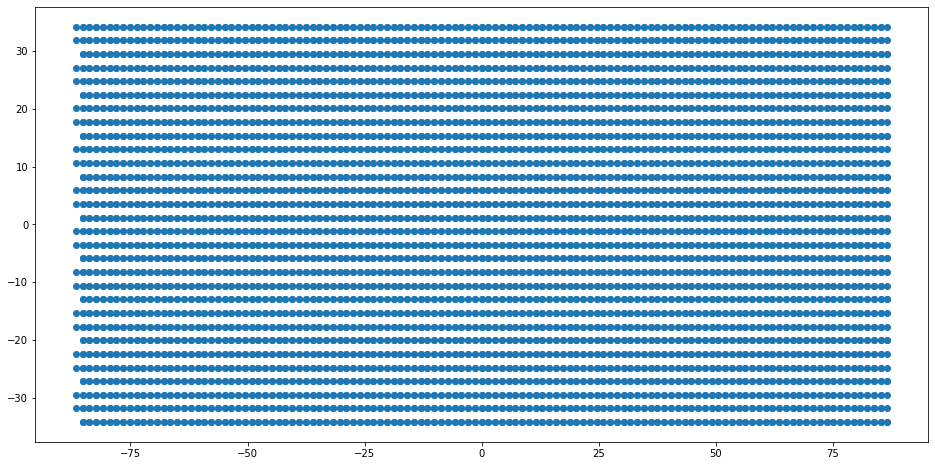

In [14]:
system = rcell.supersize(1, (-15, 15), (-5, 5)) # Way too small, only for demo purposes
print(system.natoms, 'atoms in system')
fig = plt.figure(figsize=(16,8))
plt.plot(system.atoms.pos[:, 1], system.atoms.pos[:, 2], 'o')

Insert a dislocation into the system - atoms may be deleted if the dislocation has an edge component

7140 atoms in dislocation system


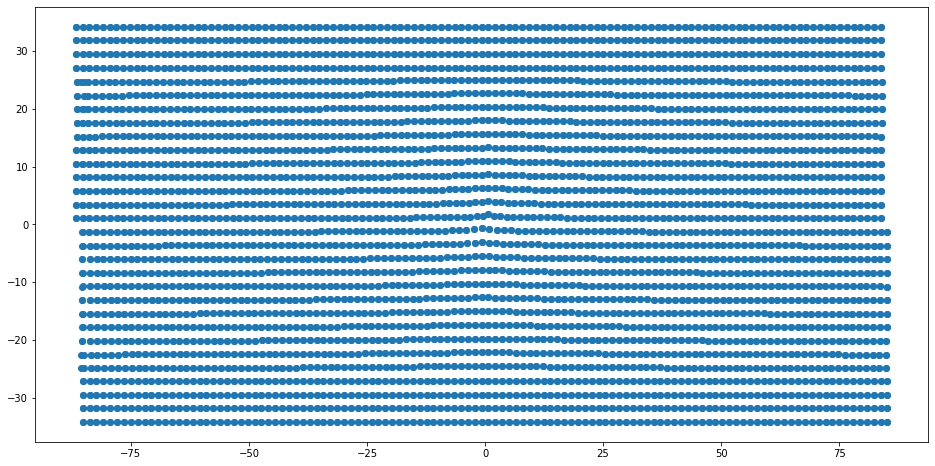

In [15]:
dislsystem = am.defect.dislocation_array(system, solution, cutoff=1)
print(dislsystem.natoms, 'atoms in dislocation system')
fig = plt.figure(figsize=(16,8))
plt.plot(dislsystem.atoms.pos[:, 1], dislsystem.atoms.pos[:, 2], 'o')

## Build bigger system

In [16]:
system = rcell.supersize(1, (-80, 80), (-20, 20))
print(system.natoms, 'atoms in system')

dislsystem = am.defect.dislocation_array(system, solution)
print(dislsystem.natoms, 'atoms in dislocation system')

153600 atoms in system
153360 atoms in dislocation system


In [17]:
# Change atom types for boundary atoms
bwidth = 10
zlo = dislsystem.box.zlo + bwidth
zhi = dislsystem.box.zhi - bwidth

plane1 = am.region.Plane(normal=[0, 0, 1], point=[0, 0, zlo])
plane2 = am.region.Plane(normal=[0, 0, 1], point=[0, 0, zhi])

print(plane1.below(dislsystem.atoms.pos).sum(), 'atoms below lower boundary plane')
print(plane2.above(dislsystem.atoms.pos).sum(), 'atoms above upper boundary plane')

dislsystem.atoms.atype[plane1.below(dislsystem.atoms.pos)
                      |plane2.above(dislsystem.atoms.pos)] = 2
dislsystem.symbols = system.symbols*2

5104 atoms below lower boundary plane
5120 atoms above upper boundary plane


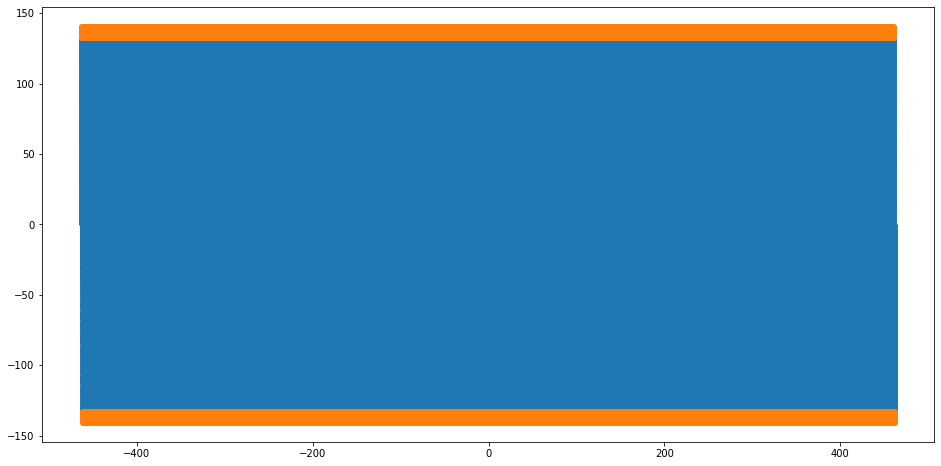

In [18]:
fig = plt.figure(figsize=(16,8))
plt.plot(dislsystem.atoms.pos[dislsystem.atoms.atype==1, 1], dislsystem.atoms.pos[dislsystem.atoms.atype==1, 2], 'o')
plt.plot(dislsystem.atoms.pos[dislsystem.atoms.atype==2, 1], dislsystem.atoms.pos[dislsystem.atoms.atype==2, 2], 'o')

## Relax in LAMMPS

Define a template LAMMPS script

In [19]:
template = """
<atomman_system_pair_info>

# Type 2 atoms are the fixed boundary atoms
group bounds type 2

compute peatom all pe/atom

dump first all custom <maxeval> *.dump id type x y z c_peatom
dump_modify first format float %.13e
thermo_style custom step pe

fix boundary bounds setforce 0.0 0.0 0.0

min_modify dmax <dmax>

minimize <etol> <ftol> <maxiter> <maxeval>
"""

Set input parameters

In [20]:
lammps_parameters = {}

# Minimization parameters
lammps_parameters['dmax'] = uc.set_in_units(0.01, 'angstrom')
lammps_parameters['etol'] = 0.0
lammps_parameters['ftol'] = 1e-8
lammps_parameters['maxiter'] = 100000
lammps_parameters['maxeval'] = 1000000

# Save structure as data file, generate potential and load commands
system_info = dislsystem.dump('atom_data', f='init.dat',
                          potential=potential,
                          return_pair_info=True)
lammps_parameters['atomman_system_pair_info'] = system_info

# Fill template
lammps_script = am.tools.filltemplate(template, lammps_parameters, '<', '>')
with open('relax.in', 'w') as f:
    f.write(lammps_script)
print(lammps_script)


# Script and atom data file prepared using atomman Python package

units metal
atom_style atomic

boundary p p m
read_data init.dat

mass 1 107.8682
mass 2 107.8682

pair_style eam/fs
pair_coeff * * 1987--Ackland-G-J--Ag--LAMMPS--ipr2\Ag_v2.eam.fs Ag Ag


# Type 2 atoms are the fixed boundary atoms
group bounds type 2

compute peatom all pe/atom

dump first all custom 1000000 *.dump id type x y z c_peatom
dump_modify first format float %.13e
thermo_style custom step pe

fix boundary bounds setforce 0.0 0.0 0.0

min_modify dmax 0.01

minimize 0.0 1e-08 100000 1000000



Run

In [21]:
log = lmp.run('lmp_mpi', 
              'relax.in', 
              mpi_command='C:/Program Files/MPICH2/bin/mpiexec -localonly 6')
log.simulations[0]['thermo']

,Step,PotEng
0,0,-454165.53
1,1123,-454351.05


In [22]:
# Load relaxed system
fstep = log.simulations[0]['thermo'].Step.values[-1]
relaxedsystem = am.load('atom_dump', f'{fstep}.dump')

Compute disregistry

In [23]:
# modsystem is the original perfect system without the deleted atoms
modsystem = system.atoms_ix[dislsystem.atoms.old_id]

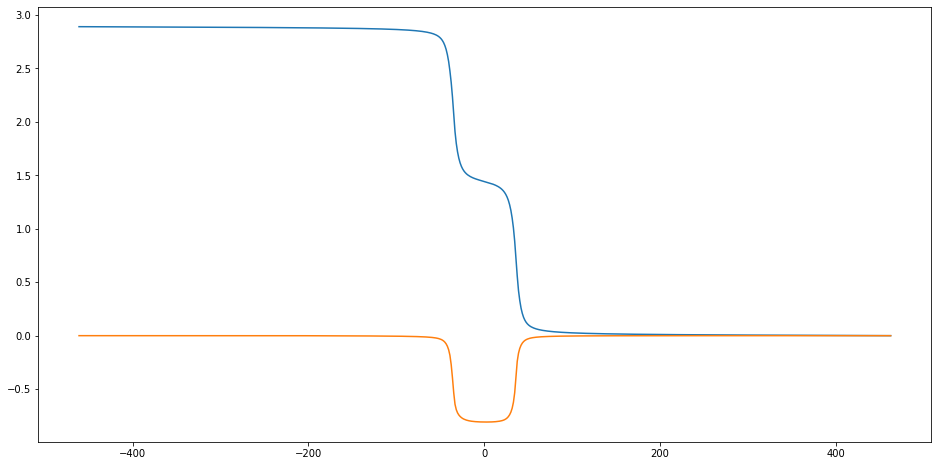

In [24]:
x, disregistry = am.defect.disregistry(modsystem, relaxedsystem, solution.m, solution.n)
fig = plt.figure(figsize=(16,8))
plt.plot(x, disregistry[:, 1])
plt.plot(x, disregistry[:, 0])

Calculate Nye tensor

In [25]:
cutoff = ucell.box.a * 0.9
p_vectors = nye = am.defect.nye_tensor_p(modsystem, cutoff=cutoff)
nye = am.defect.nye_tensor(relaxedsystem, p_vectors, cutoff=cutoff)

nye_xx = nye['Nye_tensor'][:, 0, 0]
nye_xy = nye['Nye_tensor'][:, 0, 1]
nye_xz = nye['Nye_tensor'][:, 0, 2]
nye_max = np.abs(np.hstack([nye_xx, nye_xy, nye_xz])).max()

Plot Nye tensor

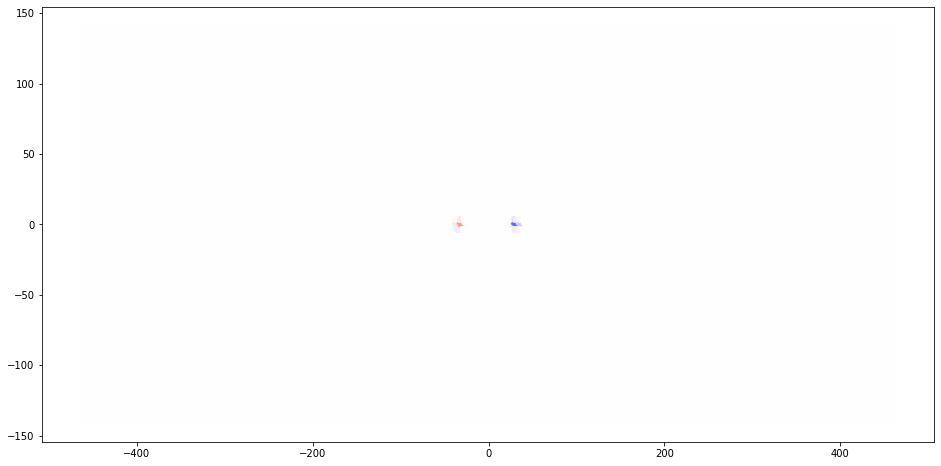

In [26]:
fig = plt.figure(figsize=(16,8))
plt.scatter(dislsystem.atoms.pos[:, 1], dislsystem.atoms.pos[:, 2], c=nye_xx, cmap='bwr', vmin=-nye_max, vmax=nye_max)
plt.show()

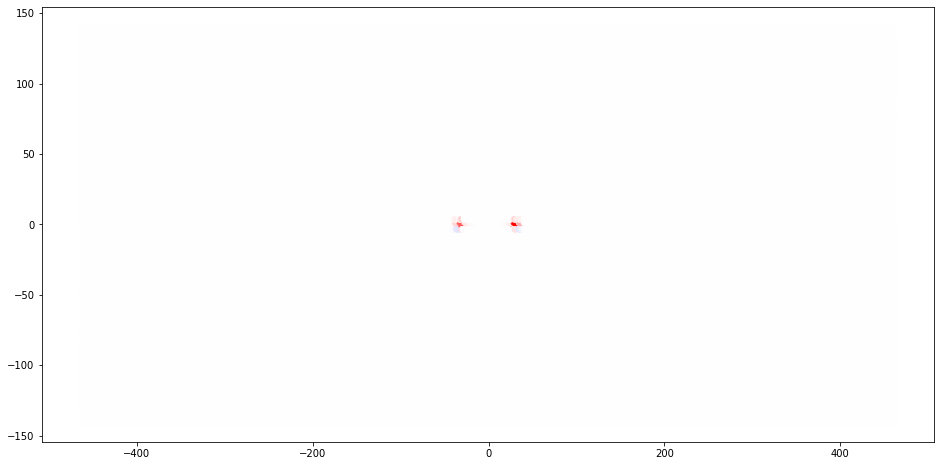

In [27]:
fig = plt.figure(figsize=(16,8))
plt.scatter(dislsystem.atoms.pos[:, 1], dislsystem.atoms.pos[:, 2], c=nye_xy, cmap='bwr', vmin=-nye_max, vmax=nye_max)
plt.show()

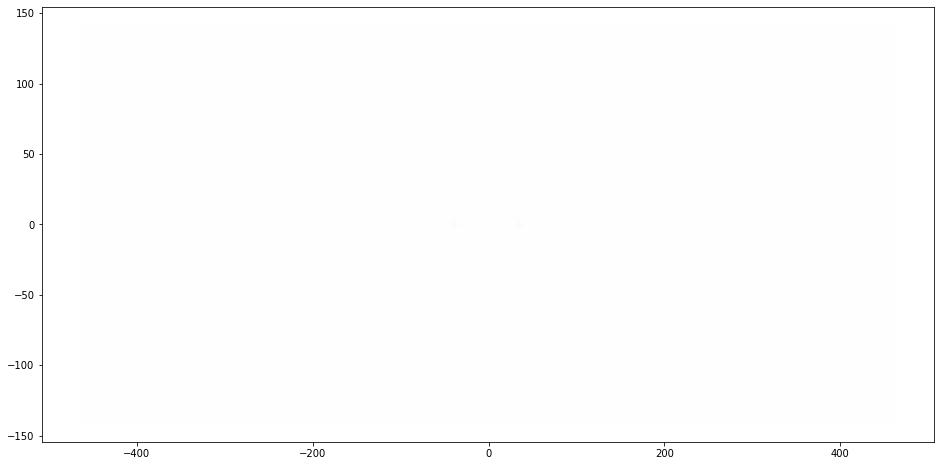

In [28]:
fig = plt.figure(figsize=(16,8))
plt.scatter(dislsystem.atoms.pos[:, 1], dislsystem.atoms.pos[:, 2], c=nye_xz, cmap='bwr', vmin=-nye_max, vmax=nye_max)
plt.show()